# Aim of the notebook. 
In this notebook you'll observe the following points addressed. 

1. Importance of class balance in classification.
2. Models with and without feature engineering to address the importance of feature engineering.
3. Analysis of different ML models.
4. Importance of cross-validation and maintaining the history.


# Loading requiered libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format


# Reading input data and basic analysis

In [2]:
# Reading the input data

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)
train.head(2)  

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000371904215119486,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
1,10000918755742328737,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe,1,0,20632,320,50,2374,3,39,-1,23


In [3]:
# Reading the test data.

test = pd.read_csv('../input/avazu-ctr-prediction/test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51


In [123]:
# shape of the data read. 

print('Train dataset:',train.shape)
print('Test dataset:',test.shape)

Train dataset: (5000000, 24)
Test dataset: (4577464, 9)


In [6]:
# hour column contains event date with all the details, extracting the same to create different columns.

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10000371904215119486,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79,10,1,21,0
1,10000918755742328737,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe,1,0,20632,320,50,2374,3,39,-1,23,10,1,21,0


In [7]:
# checking the sum of the null values across all cloumns and rows.

train['hour'].isnull().sum().sum()

0

In [8]:
# info on each column of training dataset.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [9]:
# No null values found in the dataset.

train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour_time           0
dtype: int64

In [10]:
# looks like following columns have outliers  C15, C16, C19, C21. 

train.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
count,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00
mean,9221458314803389440.00,0.17,1004.97,0.29,1.02,0.33,18841.87,318.89,60.11,2112.64,1.43,227.26,53191.70,83.37,10.00,2.60,25.47,11.28
std,5324765661351422976.00,0.38,1.10,0.51,0.53,0.86,4958.30,21.24,47.32,609.24,1.33,351.10,49958.44,70.28,0.00,1.73,2.96,5.95
min,4886763614277.00,0.00,1001.00,0.00,0.00,0.00,375.00,120.00,20.00,112.00,0.00,33.00,-1.00,1.00,10.00,0.00,21.00,0.00
25%,4611510049746534912.00,0.00,1005.00,0.00,1.00,0.00,16920.00,320.00,50.00,1863.00,0.00,35.00,-1.00,23.00,10.00,1.00,23.00,7.00
50%,9221050788454474752.00,0.00,1005.00,0.00,1.00,0.00,20346.00,320.00,50.00,2323.00,2.00,39.00,100048.00,61.00,10.00,2.00,26.00,11.00
75%,13835299280420061184.00,0.00,1005.00,1.00,1.00,0.00,21894.00,320.00,50.00,2526.00,3.00,171.00,100094.00,101.00,10.00,4.00,28.00,16.00
max,18446742062377164800.00,1.00,1012.00,7.00,5.00,5.00,24052.00,1024.00,1024.00,2758.00,3.00,1839.00,100248.00,255.00,10.00,6.00,30.00,23.00


In [11]:
# Dealing with outliers by capping

col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles

In [12]:
# segrigating numerical and categorical variables.

numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


0   0.83
1   0.17
Name: click, dtype: float64




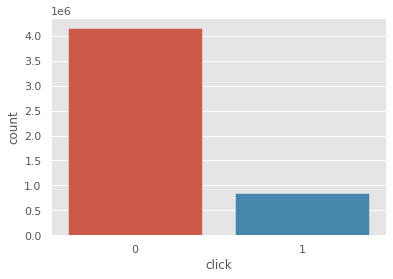

In [13]:
# y is the target variable, analysing the same.
# 83% values are 0 and 17% values are 1. data is highly imbalance. 

print(train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

# Analysing categorical variables.

In [14]:
print("unique counts of site_id", len(train['site_id'].unique()))
print("----------------------")
print(train['site_id'].value_counts(normalize = True))

unique counts of site_id 3546
----------------------
85f751fd   0.36
1fbe01fe   0.16
e151e245   0.07
d9750ee7   0.02
5b08c53b   0.02
           ... 
2fe3eeed   0.00
70d3bd49   0.00
0aa85766   0.00
123d0aa5   0.00
09a7c5b6   0.00
Name: site_id, Length: 3546, dtype: float64


In [15]:
print("unique counts of site_domain", len(train['site_domain'].unique()))
print("----------------------")
print(train['site_domain'].value_counts(normalize = True))

unique counts of site_domain 4487
----------------------
c4e18dd6   0.37
f3845767   0.16
7e091613   0.08
7687a86e   0.03
98572c79   0.02
           ... 
af6d2d6a   0.00
cc113439   0.00
85ac51ce   0.00
ca1222dc   0.00
25f262d2   0.00
Name: site_domain, Length: 4487, dtype: float64


In [16]:
print("unique counts of site_category", len(train['site_category'].unique()))
print("----------------------")
print(train['site_category'].value_counts(normalize = True))

unique counts of site_category 24
----------------------
50e219e0   0.41
f028772b   0.31
28905ebd   0.18
3e814130   0.08
f66779e6   0.01
75fa27f6   0.00
335d28a8   0.00
76b2941d   0.00
c0dd3be3   0.00
72722551   0.00
dedf689d   0.00
70fb0e29   0.00
0569f928   0.00
8fd0aea4   0.00
a818d37a   0.00
42a36e14   0.00
e787de0e   0.00
bcf865d9   0.00
5378d028   0.00
9ccfa2ea   0.00
da34532e   0.00
74073276   0.00
110ab22d   0.00
c706e647   0.00
Name: site_category, dtype: float64


In [17]:
print("unique counts of app_id", len(train['app_id'].unique()))
print("----------------------")
print(train['app_id'].value_counts(normalize = True))

unique counts of app_id 5151
----------------------
ecad2386   0.64
92f5800b   0.04
e2fcccd2   0.03
febd1138   0.02
9c13b419   0.02
           ... 
5d13bb32   0.00
6f9c1332   0.00
0d42c22c   0.00
54c1a6e5   0.00
5d821cf4   0.00
Name: app_id, Length: 5151, dtype: float64


In [18]:
print("unique counts of app_domain", len(train['app_domain'].unique()))
print("----------------------")
print(train['app_domain'].value_counts(normalize = True))

unique counts of app_domain 311
----------------------
7801e8d9   0.67
2347f47a   0.13
ae637522   0.05
5c5a694b   0.03
82e27996   0.02
           ... 
09abdb18   0.00
6de3d639   0.00
bf2623ab   0.00
6cf43c3b   0.00
8bba499a   0.00
Name: app_domain, Length: 311, dtype: float64


In [19]:
print("unique counts of app_category", len(train['app_category'].unique()))
print("----------------------")
print(train['app_category'].value_counts(normalize = True))

unique counts of app_category 30
----------------------
07d7df22   0.65
0f2161f8   0.24
cef3e649   0.04
8ded1f7a   0.04
f95efa07   0.03
d1327cf5   0.00
dc97ec06   0.00
09481d60   0.00
75d80bbe   0.00
fc6fa53d   0.00
4ce2e9fc   0.00
879c24eb   0.00
a3c42688   0.00
4681bb9d   0.00
0f9a328c   0.00
a86a3e89   0.00
2281a340   0.00
8df2e842   0.00
79f0b860   0.00
0bfbc358   0.00
7113d72a   0.00
a7fd01ec   0.00
18b1e0be   0.00
2fc4f2aa   0.00
5326cf99   0.00
4b7ade46   0.00
86c1a5a3   0.00
71af18ce   0.00
0d82db25   0.00
bf8ac856   0.00
Name: app_category, dtype: float64


In [20]:
print("unique counts of device_id", len(train['device_id'].unique()))
print("----------------------")
print(train['device_id'].value_counts(normalize = True))

unique counts of device_id 598473
----------------------
a99f214a   0.83
0f7c61dc   0.00
c357dbff   0.00
936e92fb   0.00
afeffc18   0.00
           ... 
04bf9ce0   0.00
ad05c317   0.00
16c987c1   0.00
bef44eab   0.00
2e7d4e84   0.00
Name: device_id, Length: 598473, dtype: float64


In [21]:
print("unique counts of device_ip", len(train['device_ip'].unique()))
print("----------------------")
print(train['device_ip'].value_counts(normalize = True))

unique counts of device_ip 1905743
----------------------
6b9769f2   0.01
431b3174   0.00
2f323f36   0.00
af9205f9   0.00
930ec31d   0.00
           ... 
de759d98   0.00
c97c4183   0.00
fde2330b   0.00
38f3b046   0.00
e1b5bcff   0.00
Name: device_ip, Length: 1905743, dtype: float64


In [22]:
print("unique counts of device_model", len(train['device_model'].unique()))
print("----------------------")
print(train['device_model'].value_counts(normalize = True))

unique counts of device_model 6587
----------------------
8a4875bd   0.06
1f0bc64f   0.04
d787e91b   0.03
76dc4769   0.02
be6db1d7   0.02
           ... 
e9378a9c   0.00
582c9ea2   0.00
733df5c6   0.00
2046d3d3   0.00
19ba748a   0.00
Name: device_model, Length: 6587, dtype: float64


## observations :
1. All categorical variables have lot of unique values in it, one hot encoding is not a scalable approach. 
2. we will go with label encoding and scaling approach is a better idea for this.

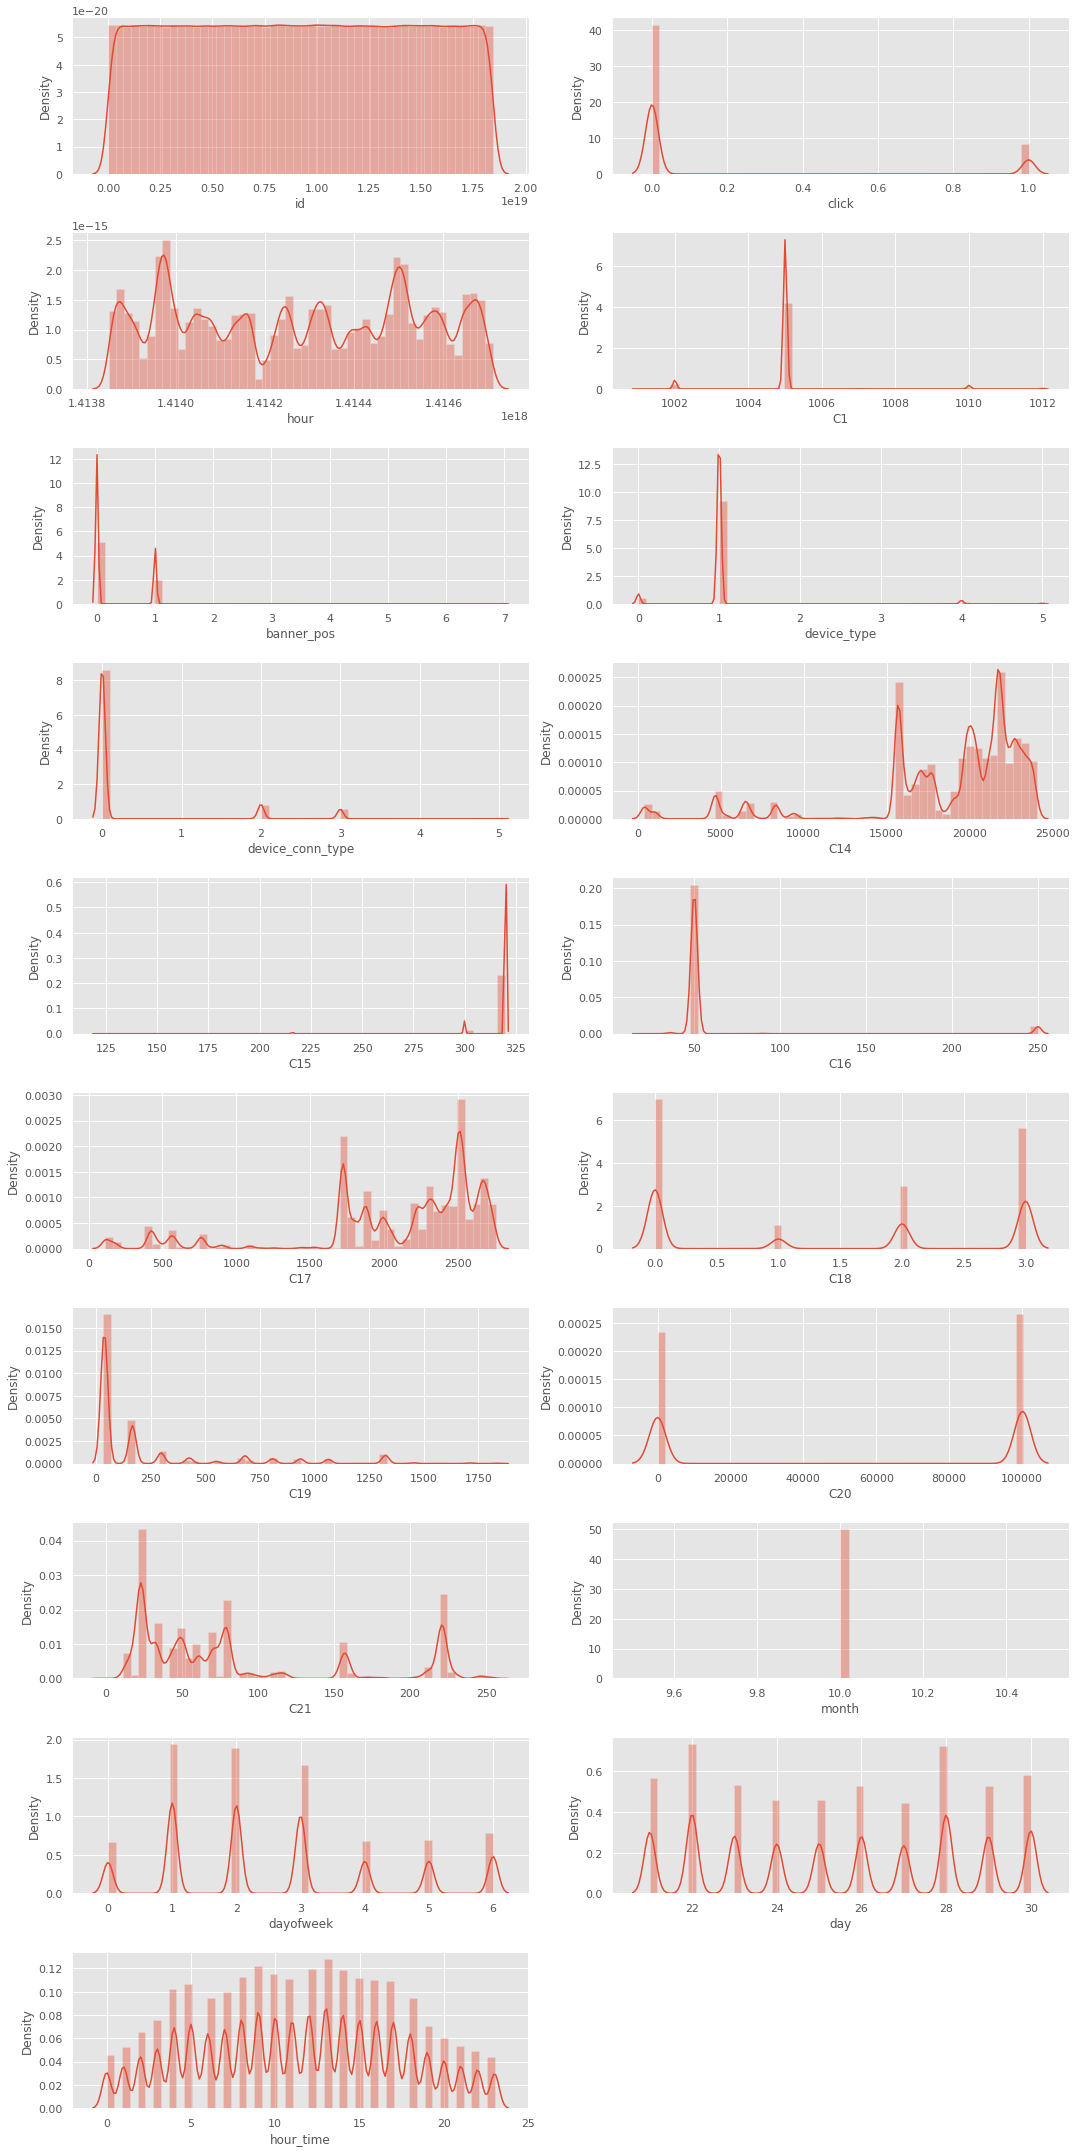

In [23]:
# The code below will plot histograms for all numerical columns 

n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.distplot(train[numerical[i]])

plt.tight_layout()
plt.show()

## observations 
1. Y and Click looks like same columns, after co-relation we can drop on of them.
2. month column has only 1 data entry, no exrtra information is added, can be dropped 
3. banner pos, device conn, C20, C15, C16 looks like data is cenetered around certain values. 


In [24]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek',
       'day', 'hour_time'],
      dtype='object')

Text(0.5, 1.05, 'Pearson correlation of Features')

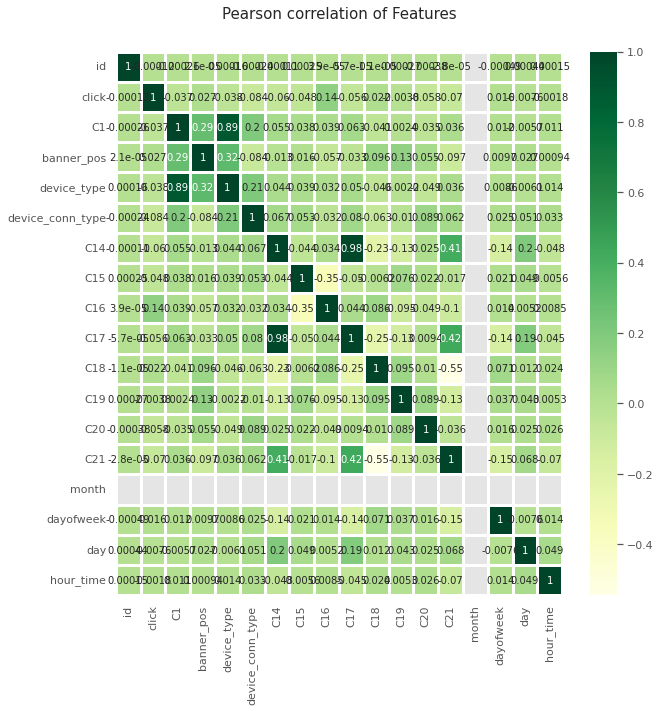

In [25]:
# Pearson correlation table to find the relationship with output with all input features. 

corr = train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

## observation
1. month has got no significance, better to drop it
2. y and click are same drop click column 
3. C14 and C17 are highly co-related, later will remove one of them after the base model.
4. device type with C1 are highly co-related, later will remove one of them after the base model.
5. Removing C20 anomalised column, since it have got nearly 47% of values with -1. As a categorical variable
it's not expected to have values as -1.

In [26]:
# as said above dropping columns. 

train.drop(['month', 'C20'], axis=1, inplace=True)
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day',
       'hour_time'],
      dtype='object')

# Data preperation


In [27]:
# id column have a unique columns so, keeping that don't proive any significance,hence dropping.
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

train.drop(['id', 'hour'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [28]:
# dataset is huge and running multiple algo will take time and resources might exhaust, 
# hence taking only 10% of the data for analysis.

sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

0   0.83
1   0.17
Name: y, dtype: float64




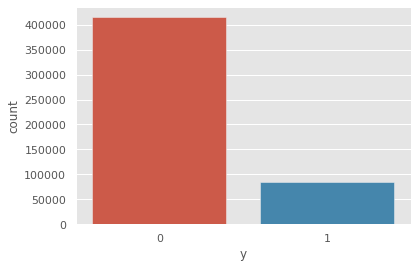

In [29]:
# After taking the sample of data, still the ratio of output remains same.

print(train.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

In [30]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.27,0.14,1,0,23193,320,50,2671,0,163,221,1,28,10
4993932,1005,0,0.12,0.12,0.13,0.31,0.14,0.25,0.17,0.17,0.18,1,0,23161,320,50,2667,0,47,221,3,30,23


In [31]:
'''
target_encoder = ce.TargetEncoder()
for col in (X.columns):
    if X[col].dtype == "object":
        X[col] = target_encoder.fit_transform(X[col], y)

X.head(2)
'''

'\ntarget_encoder = ce.TargetEncoder()\nfor col in (X.columns):\n    if X[col].dtype == "object":\n        X[col] = target_encoder.fit_transform(X[col], y)\n\nX.head(2)\n'

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

# Building basic models [no feature engineering]
 1. in this no feature engineering is done apart from removing definate columns click and month.
 2. We will run 3 models 
      a. Logistic regression [for explainability and finding linear relationship]
      b. Decision tree classifier [for explainability and also for non-linear relation]
      c. Random forest classifier [for accuracy and improving the model] 
 3. Target variable is highly imbalance, so model will be baised towards majority class. for every base model will try with both balance and imbalance data.

## defining functions for later use.

In [34]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

In [35]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, Xtest, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [36]:
# Returns the ctossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [37]:
# this stores the results in dataframe for evaluating the final result. 

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

## Dummy classifier for verification
Dummy classifier helps in baseling the model performace w.r.t dominanat class. 

In [38]:
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy, cnf_matrix  = model_eval(dummy_clf, X_train, y_train)
print(accuracy)
print(cnf_matrix)
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
outcome = outcome.append(temp)
outcome

0.82988
[[290458      0]
 [ 59542      0]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83


## Basic regression model with imbalance precidtor 

In [39]:
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4012287,1005,1,0.13,0.13,0.18,0.20,0.19,0.20,0.17,0.17,0.15,1,0,8330,320,50,761,3,175,23,2,29,0
540137,1005,1,0.26,0.26,0.18,0.20,0.19,0.20,0.17,0.05,0.17,1,0,21153,320,50,2420,2,35,69,2,22,2
4371566,1005,1,0.10,0.26,0.18,0.20,0.19,0.20,0.17,0.10,0.08,1,0,23626,320,50,2707,3,937,61,2,29,16
3105063,1002,0,0.63,0.12,0.13,0.20,0.19,0.20,0.17,0.40,0.21,0,0,22700,320,50,2624,0,35,221,0,27,9
2187836,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.24,0.17,1,0,15704,320,50,1722,0,35,79,5,25,10


In [40]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4012287,0.36,0.14,0.13,0.13,0.35,0.20,0.22,0.80,0.19,0.17,0.16,0.20,0.00,0.34,1.00,0.13,0.25,1.00,0.08,0.09,0.33,0.89,0.00
540137,0.36,0.14,0.27,0.27,0.35,0.20,0.22,0.80,0.19,0.05,0.18,0.20,0.00,0.88,1.00,0.13,0.87,0.67,0.00,0.27,0.33,0.11,0.09
4371566,0.36,0.14,0.10,0.27,0.35,0.20,0.22,0.80,0.19,0.10,0.08,0.20,0.00,0.98,1.00,0.13,0.98,1.00,0.50,0.24,0.33,0.89,0.70
3105063,0.09,0.00,0.66,0.13,0.25,0.20,0.22,0.80,0.19,0.40,0.22,0.00,0.00,0.94,1.00,0.13,0.95,0.00,0.00,0.87,0.00,0.67,0.39
2187836,0.36,0.00,0.21,0.21,0.41,0.20,0.22,0.80,0.19,0.24,0.18,0.20,0.00,0.65,1.00,0.13,0.61,0.00,0.00,0.31,0.83,0.44,0.43


In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [42]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3088794,0.36,0.14,0.31,0.27,0.35,0.20,0.22,0.80,0.19,0.17,0.28,0.20,0.00,0.18,1.00,0.13,0.12,0.67,0.00,0.12,0.00,0.67,0.35
1491505,0.36,0.00,0.12,0.13,0.25,0.23,0.14,0.76,0.19,0.09,0.09,0.20,0.00,0.80,1.00,0.13,0.80,0.00,0.36,0.19,0.50,0.22,0.65


In [43]:
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - imbalance predict", y_train, X_train, y_test, X_test, model, 5)
outcome = outcome.append(temp)
outcome

0.8437066666666667
[[121084   3398]
 [ 20046   5472]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84


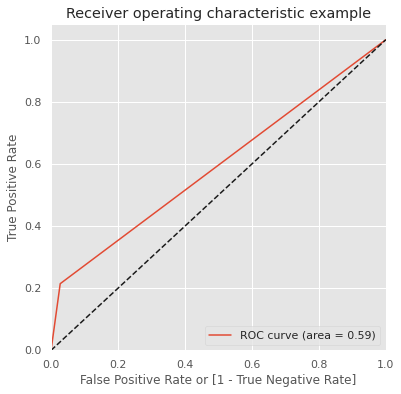

(array([0.        , 0.02729712, 1.        ]),
 array([0.        , 0.21443687, 1.        ]),
 array([2, 1, 0]))

In [44]:
draw_roc(model, X_test, y_test)

### Observation
1. Logistic regression is behaving almost same as dummy classifier.
2. ROC_AUC isn't doing better at all

## Basic regression model with balance precidtor 

Original dataset shape  Counter({0: 414940, 1: 85060})
Resampled dataset shape Counter({0: 414940, 1: 414940})


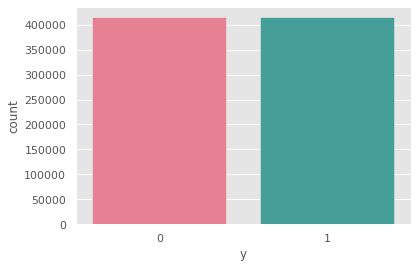

In [45]:
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [46]:
x_new.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.27,0.14,1,0,23193,320,50,2671,0,163,221,1,28,10
1,1005,0,0.12,0.12,0.13,0.31,0.14,0.25,0.17,0.17,0.18,1,0,23161,320,50,2667,0,47,221,3,30,23


In [47]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [48]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,0.36,0.00,0.12,0.13,0.25,0.06,0.16,0.44,0.19,0.00,0.00,0.20,0.40,0.90,1.00,0.13,0.91,0.00,0.00,0.61,0.33,0.11,0.52
160654,0.36,0.00,0.12,0.13,0.25,0.08,0.08,0.44,0.19,0.01,0.17,0.20,0.00,0.99,1.00,0.13,0.99,1.00,0.43,0.90,0.50,1.00,0.17


In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

0.7219959512218634
[[90426 34056]
 [35157 89325]]


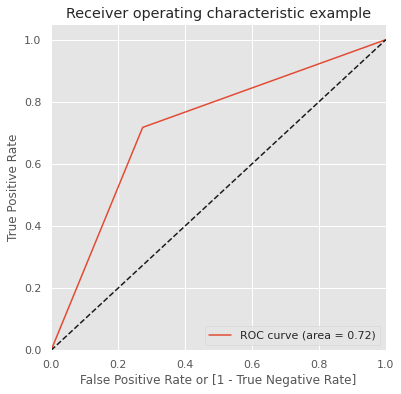

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72


In [50]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - balance predict", y_train, X_train, y_test, X_test, model, 5)
draw_roc(model, X_test, y_test)
outcome = outcome.append(temp)
outcome

##  Decision tree classifier with unbalanced data 

In [51]:
# decision tree doesn't require feature scaling, will use the raw features directly 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4012287,1005,1,0.13,0.13,0.18,0.20,0.19,0.20,0.17,0.17,0.15,1,0,8330,320,50,761,3,175,23,2,29,0
540137,1005,1,0.26,0.26,0.18,0.20,0.19,0.20,0.17,0.05,0.17,1,0,21153,320,50,2420,2,35,69,2,22,2


0.7766933333333333
[[107464  17018]
 [ 16478   9040]]


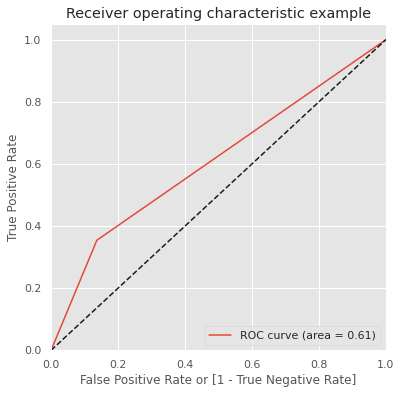

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78


In [52]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("decision tree basic - imbalance predict", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = outcome.append(temp)
outcome


##  Decision tree classifier with balanced data 


In [53]:
# x_new and y_new are already calculated before for balanced dataset using the same.

X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,1005,0,0.12,0.12,0.13,0.06,0.14,0.11,0.17,0.00,0.00,1,2,21769,320,50,2507,0,35,157,2,22,12
160654,1005,0,0.12,0.12,0.13,0.08,0.07,0.11,0.17,0.01,0.16,1,0,23804,320,50,2726,3,803,229,3,30,4


0.8956636300830643
[[102413  22069]
 [  3907 120575]]


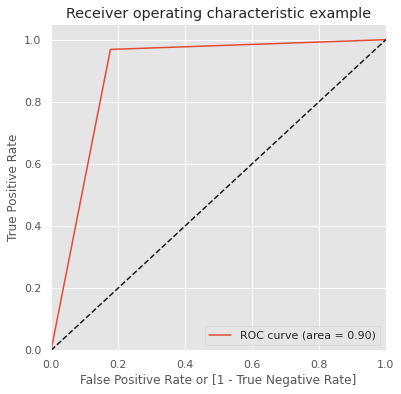

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88


In [54]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("decision tree basic - balance predict", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = outcome.append(temp)
outcome

### observation 
1. decision tree on unbalanced data isn't doing that great.
1. decision tree on balanced data is really doing very good. 
2. decision tree on balanced data on test data as well as cross validation is doing really well.
4. ROC_AUC curve looks really good.

## Random forest classifier with imbalanced data 


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4012287,1005,1,0.13,0.13,0.18,0.20,0.19,0.20,0.17,0.17,0.15,1,0,8330,320,50,761,3,175,23,2,29,0
540137,1005,1,0.26,0.26,0.18,0.20,0.19,0.20,0.17,0.05,0.17,1,0,21153,320,50,2420,2,35,69,2,22,2


0.8231066666666667
[[116583   7899]
 [ 18635   6883]]


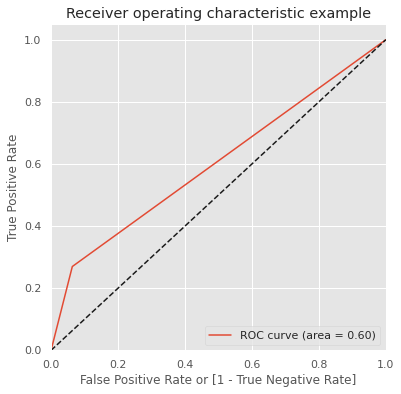

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83


In [56]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - imbalance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = outcome.append(temp)
outcome


## Random forest classifier with balanced data 


In [57]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,1005,0,0.12,0.12,0.13,0.06,0.14,0.11,0.17,0.00,0.00,1,2,21769,320,50,2507,0,35,157,2,22,12
160654,1005,0,0.12,0.12,0.13,0.08,0.07,0.11,0.17,0.01,0.16,1,0,23804,320,50,2726,3,803,229,3,30,4


0.9072677174209925
[[104703  19779]
 [  3308 121174]]


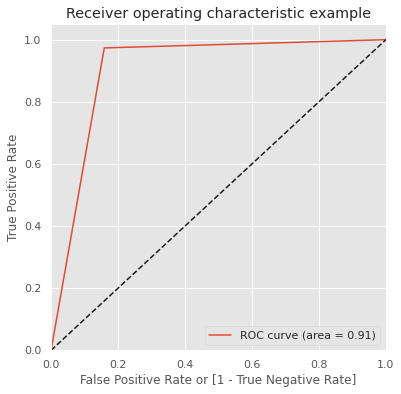

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89


In [59]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - balance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = outcome.append(temp)
outcome

### observarion :
 1. Random forest data with imbalance data is over fitted for training data.
 1. Random forest with balanced data set is performing the best so far on both train and test data.
 2. Random forest with balanced data holding good for cross validation as well.
 Conclusion based on simple models built  :- Random forest on balanced data set is the best model built


# XG Boost classifier with imbalanced data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4012287,1005,1,0.13,0.13,0.18,0.20,0.19,0.20,0.17,0.17,0.15,1,0,8330,320,50,761,3,175,23,2,29,0
540137,1005,1,0.26,0.26,0.18,0.20,0.19,0.20,0.17,0.05,0.17,1,0,21153,320,50,2420,2,35,69,2,22,2


0.84648
[[121362   3120]
 [ 19908   5610]]


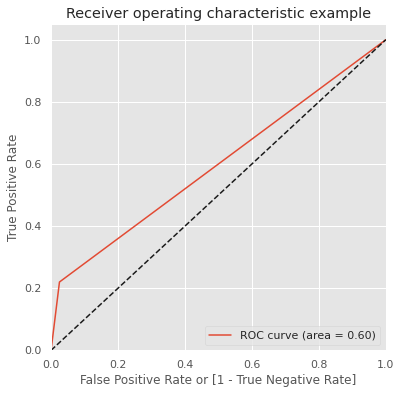

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85


In [63]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)
y_preds = model_xgb.predict(X_test)
accuracy, cnf_matrix = model_eval(model_xgb, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("XGBoost basic - imbalance predict", y_train, X_train, y_test, X_test, model_xgb, 5)
draw_roc(model_xgb, X_test, y_test)
outcome = outcome.append(temp)
outcome

# XG Boost classifier with balanced data

In [64]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,1005,0,0.12,0.12,0.13,0.06,0.14,0.11,0.17,0.00,0.00,1,2,21769,320,50,2507,0,35,157,2,22,12
160654,1005,0,0.12,0.12,0.13,0.08,0.07,0.11,0.17,0.01,0.16,1,0,23804,320,50,2726,3,803,229,3,30,4


0.7498433508459055
[[ 84424  40058]
 [ 22222 102260]]


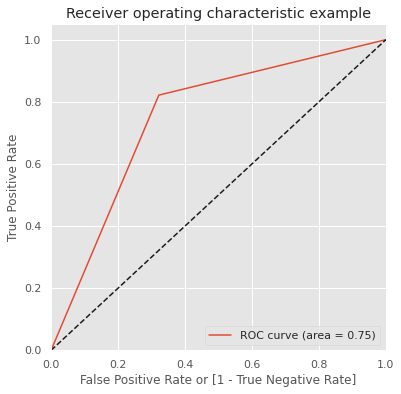

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XG Boost basic - balance predict,0.75,0.72,0.82,0.75,0.72,0.82,0.75,0.75,0.75,0.75,0.75,0.75


In [65]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)
y_preds = model_xgb.predict(X_test)
accuracy, cnf_matrix = model_eval(model_xgb, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("XG Boost basic - balance predict", y_train, X_train, y_test, X_test, model_xgb, 5)
draw_roc(model_xgb, X_test, y_test)
outcome = outcome.append(temp)
outcome

# Building basic models [with feature engineering]
 in this will follow on building same models as before.
 1. Logistic regression.
 2. Decision tree classifier.
 3. Random forest Classifier.
 One Important observation : While building, we observed that building with balanced predictor is a better apporach. hence all the 3 models in feature engineering case will be built using balanced data set only. 

In [66]:
data_feature = sampled_data.copy()

Text(0.5, 1.05, 'Pearson correlation of Features')

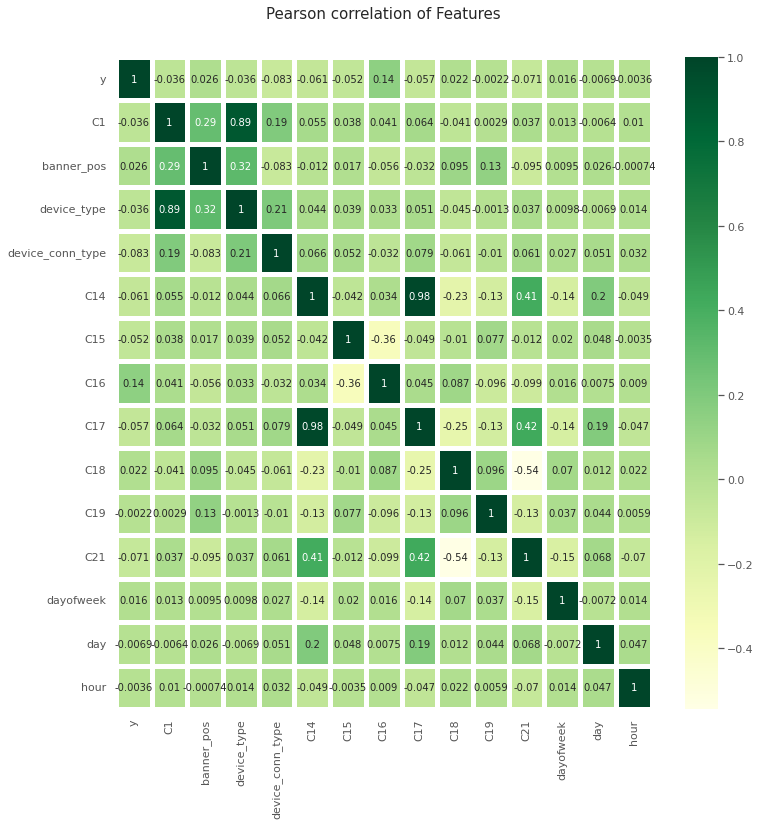

In [67]:
corr = data_feature.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)


In [68]:
# C1 and device_type are highly corelated, since C1 is anomalised column we can drop it.
# C14 and C17 are highly co-related, dropping either is a good idea.

data_feature.drop(['C14', 'C1'], axis=1, inplace= True)

In [69]:
X = data_feature.drop(['y'], axis=1)
y = data_feature['y']

In [70]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.27,0.14,1,0,320,50,2671,0,163,221,1,28,10
4993932,0,0.12,0.12,0.13,0.31,0.14,0.25,0.17,0.17,0.18,1,0,320,50,2667,0,47,221,3,30,23


Original dataset shape  Counter({0: 414940, 1: 85060})
Resampled dataset shape Counter({0: 414940, 1: 414940})


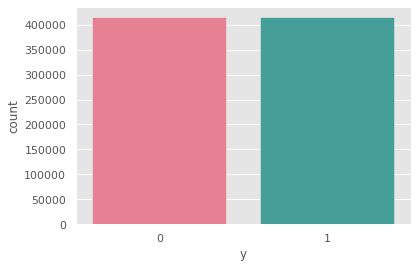

In [71]:
# As discussed at the start, we will use balanced data for all the 
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

## Logistic regression model with feature engineering and balance precidtor.

In [73]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,0.00,0.12,0.13,0.25,0.06,0.16,0.44,0.19,0.00,0.00,0.20,0.40,1.00,0.13,0.91,0.00,0.00,0.61,0.33,0.11,0.52
160654,0.00,0.12,0.13,0.25,0.08,0.08,0.44,0.19,0.01,0.17,0.20,0.00,1.00,0.13,0.99,1.00,0.43,0.90,0.50,1.00,0.17
479214,0.00,0.12,0.13,0.25,0.20,0.22,0.44,0.19,0.17,0.27,0.20,0.00,1.00,0.13,0.17,0.67,0.00,0.12,0.50,0.22,0.65
404897,0.00,0.12,0.13,0.25,0.05,0.05,0.44,0.19,0.17,0.05,0.20,0.00,1.00,0.13,0.84,0.00,0.00,0.62,0.67,0.33,0.70
138828,0.00,0.21,0.21,0.41,0.20,0.22,0.80,0.19,0.02,0.23,0.20,0.00,1.00,0.13,0.61,0.00,0.00,0.31,1.00,0.56,0.30


In [74]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580916
Model:                            GLM   Df Residuals:                   580894
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1059e+05
Date:                Fri, 22 Dec 2023   Deviance:                   6.2118e+05
Time:                        09:44:03   Pearson chi2:                 1.30e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2717
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.2363      0.084    -61.989      0.000      -5.402      -5.071
banner_pos           0.0948      0.052      1.825      0.068      -0.007       0.197
site_id              2.9560      0.076     38.892      0.000       2.807       3.105
site_domain          3.4194      0.084     40.717      0.000       3.255       3.584
site_category       -0.4795      0.048     -9.999      0.000      -0.574      -0.386
app_id               8.7202      0.084    103.272      0.000       8.555       8.886
app_domain          -3.0597      0.106    -28.977      0.000      -3.267      -2.853
app_category        -1.1500      0.028    -41.237      0.000      -1.205      -1.095
device_id            6.8664      0.169     40.545      0.000       6.535       7.198
device_ip            7.7719      0.038    202.836      0.000       7.697       7.847
device_model         3.1914      0.051     62.681      0.000       3.092       3.291
device_type          0.1662      0.040      4.141      0.000       0.088       0.245
device_conn_type     0.1872      0.025      7.466      0.000       0.138       0.236
C15                  0.8111      0.072     11.265      0.000       0.670       0.952
C16                 -0.3565      0.022    -16.108      0.000      -0.400      -0.313
C17                 -0.2289      0.015    -15.564      0.000      -0.258      -0.200
C18                 -0.0643      0.009     -7.107      0.000      -0.082      -0.047
C19                  0.2704      0.016     17.201      0.000       0.240       0.301
C21                 -0.1883      0.015    -12.705      0.000      -0.217      -0.159
dayofweek            0.0297      0.011      2.745      0.006       0.008       0.051
day                 -0.0153      0.010     -1.584      0.113      -0.034       0.004
hour                -0.1317      0.012    -10.947      0.000      -0.155      -0.108
====================================================================================
"""

In [75]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[211336  79122]
 [ 81905 208553]]
0.7228050182814727


In [76]:
def sm_model_evaluation (model, x_test, y_test):
    '''
    model = sm model
    y_test = series of labels 
    columns = list of columns in features
    x_test = test dataframe 
    '''
    X_sm = sm.add_constant(x_test)
    y_pred = res.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

In [77]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
sm_model_evaluation(res, X_test, y_test)  

0.7223775324946579
[[90369 34113]
 [35005 89477]]


In [78]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,637.58
3,site_domain,6.97
2,site_id,6.86
7,app_category,2.21
14,C16,2.14
6,app_domain,2.05
4,site_category,1.96
18,C21,1.77
5,app_id,1.70
16,C18,1.62


In [79]:
# VIF looks good, w.r.t P values hour and dayofweek have got highest, will remove and build the model.

X_train_sm.drop(['hour','day'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580916
Model:                            GLM   Df Residuals:                   580896
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1065e+05
Date:                Fri, 22 Dec 2023   Deviance:                   6.2131e+05
Time:                        09:44:33   Pearson chi2:                 1.28e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2715
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3097      0.084    -63.101      0.000      -5.475      -5.145
banner_pos           0.0924      0.052      1.779      0.075      -0.009       0.194
site_id              2.9404      0.076     38.727      0.000       2.792       3.089
site_domain          3.4161      0.084     40.711      0.000       3.252       3.581
site_category       -0.4727      0.048     -9.860      0.000      -0.567      -0.379
app_id               8.6885      0.084    103.063      0.000       8.523       8.854
app_domain          -3.0017      0.105    -28.484      0.000      -3.208      -2.795
app_category        -1.1522      0.028    -41.355      0.000      -1.207      -1.098
device_id            6.8700      0.169     40.538      0.000       6.538       7.202
device_ip            7.7737      0.038    202.920      0.000       7.699       7.849
device_model         3.1945      0.051     62.747      0.000       3.095       3.294
device_type          0.1522      0.040      3.795      0.000       0.074       0.231
device_conn_type     0.1850      0.025      7.386      0.000       0.136       0.234
C15                  0.8093      0.072     11.263      0.000       0.668       0.950
C16                 -0.3537      0.022    -15.989      0.000      -0.397      -0.310
C17                 -0.2285      0.014    -15.826      0.000      -0.257      -0.200
C18                 -0.0656      0.009     -7.255      0.000      -0.083      -0.048
C19                  0.2688      0.016     17.112      0.000       0.238       0.300
C21                 -0.1820      0.015    -12.289      0.000      -0.211      -0.153
dayofweek            0.0297      0.011      2.742      0.006       0.008       0.051
====================================================================================
"""

In [80]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,631.58
3,site_domain,6.97
2,site_id,6.85
7,app_category,2.21
14,C16,2.14
6,app_domain,2.05
4,site_category,1.96
18,C21,1.76
5,app_id,1.70
16,C18,1.62


In [81]:
X_train_sm.drop(['dayofweek','device_ip', 'C15'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580916
Model:                            GLM   Df Residuals:                   580899
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4194e+05
Date:                Fri, 22 Dec 2023   Deviance:                   6.8387e+05
Time:                        09:44:58   Pearson chi2:                 1.32e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1887
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9461      0.040    -98.465      0.000      -4.025      -3.868
banner_pos          -0.2533      0.050     -5.080      0.000      -0.351      -0.156
site_id              4.1801      0.074     56.740      0.000       4.036       4.325
site_domain          2.7020      0.081     33.480      0.000       2.544       2.860
site_category       -0.3884      0.045     -8.617      0.000      -0.477      -0.300
app_id               9.8190      0.083    118.949      0.000       9.657       9.981
app_domain          -2.4313      0.101    -24.031      0.000      -2.630      -2.233
app_category        -1.3455      0.027    -50.734      0.000      -1.397      -1.294
device_id            9.1591      0.168     54.677      0.000       8.831       9.487
device_model         4.2877      0.049     88.015      0.000       4.192       4.383
device_type          0.5205      0.038     13.630      0.000       0.446       0.595
device_conn_type     0.0897      0.024      3.783      0.000       0.043       0.136
C16                 -0.6206      0.021    -30.185      0.000      -0.661      -0.580
C17                 -0.2030      0.014    -14.792      0.000      -0.230      -0.176
C18                 -0.1221      0.009    -14.309      0.000      -0.139      -0.105
C19                  0.1976      0.015     13.323      0.000       0.169       0.227
C21                 -0.2112      0.014    -15.175      0.000      -0.239      -0.184
====================================================================================
"""

In [82]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,82.66
3,site_domain,6.97
2,site_id,6.85
7,app_category,2.20
6,app_domain,2.04
4,site_category,1.96
12,C16,1.88
16,C21,1.75
5,app_id,1.68
14,C18,1.62


### Model P values and VIF looks good, will find the best threshold for classification.

In [83]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[184535 105923]
 [ 78095 212363]]
0.6832278677123715


In [84]:
col = list(X_train_sm.columns)
col.remove('const')
sm_model_evaluation(res, X_test[col], y_test)  

0.6820664835076558
[[78973 45509]
 [33645 90837]]


In [85]:
numbers = [float(x)/20 for x in range(20)]
print(numbers)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
306155,0,0.12,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160654,0,0.24,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479214,0,0.62,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
404897,1,0.15,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
138828,0,0.58,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0


In [86]:
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    accuracy = (TP + TN)/total1
    
    recall = TP / (TP+FP)
    precision = TP / (TP+FN)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df

,Thresold_prob,accuracy,recall,precision
0.00,0.00,0.50,0.50,1.00
0.05,0.05,0.50,0.50,1.00
0.10,0.10,0.51,0.51,1.00
0.15,0.15,0.56,0.53,0.99
0.20,0.20,0.59,0.55,0.98
0.25,0.25,0.62,0.57,0.96
0.30,0.30,0.65,0.59,0.93
0.35,0.35,0.67,0.62,0.89
0.40,0.40,0.68,0.63,0.85
0.45,0.45,0.68,0.65,0.80


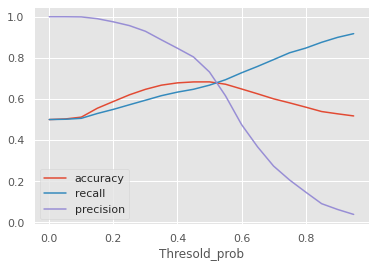

In [87]:
cutoff_df.plot.line(x='Thresold_prob', y=['accuracy','recall','precision'])
plt.show()

In [88]:
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,final_predicted
306155,0,0.12,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160654,0,0.24,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479214,0,0.62,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1
404897,1,0.15,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
138828,0,0.58,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1


In [89]:
X_train_sm.drop('const', axis= 1, inplace= True)
X_test = X_test[X_train_sm.columns]
print(X_train_sm.shape)
print(X_test.shape)

(580916, 16)
(248964, 16)


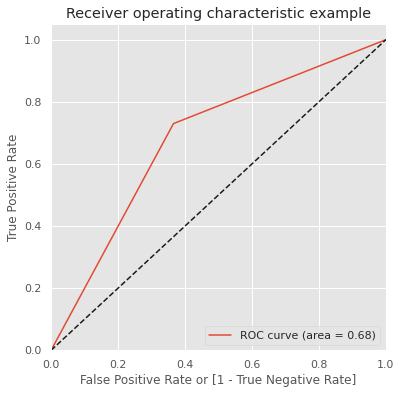

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XG Boost basic - balance predict,0.75,0.72,0.82,0.75,0.72,0.82,0.75,0.75,0.75,0.75,0.75,0.75


In [90]:
model = LogisticRegression()
model.fit(X_train_sm, y_train)
accuracy, cnf_matrix = model_eval(model, X_test[X_train_sm.columns], y_test)
temp = store_results("logistic reg with feature engine", y_train, X_train_sm, y_test, X_test[X_train_sm.columns], \
                     model, 5)
draw_roc(model, X_test[X_train_sm.columns], y_test)
outcome = outcome.append(temp)
outcome


## Decision tree model with feature engineering and balance precidtor.


In [91]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,0,0.12,0.12,0.13,0.06,0.14,0.11,0.17,0.00,0.00,1,2,320,50,2507,0,35,157,2,22,12
160654,0,0.12,0.12,0.13,0.08,0.07,0.11,0.17,0.01,0.16,1,0,320,50,2726,3,803,229,3,30,4


In [92]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train, y_train)
feature_importances = dt_tree.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.26
9,device_model,0.19
20,hour,0.15
1,site_id,0.11
19,day,0.05
4,app_id,0.04
18,dayofweek,0.04
14,C17,0.04
2,site_domain,0.02
16,C19,0.02


In [93]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

In [94]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train[rf_cols], y_train)

DecisionTreeClassifier(random_state=42)

['site_id', 'site_domain', 'app_id', 'device_ip', 'device_model', 'C17', 'C19', 'dayofweek', 'day', 'hour']
10
Train results
accuracy 0.9713297619621426
cnf_matrix 
 [[278581  11877]
 [  4778 285680]]
Test results
accuracy 0.8837462444369467
cnf_matrix 
 [[101021  23461]
 [  5482 119000]]


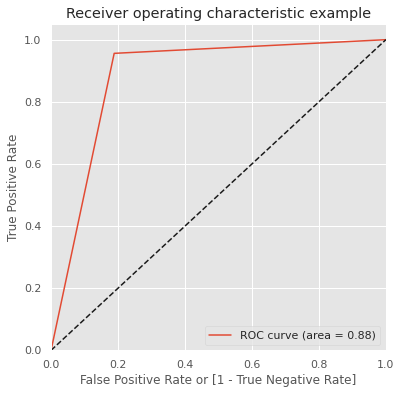

(array([0.        , 0.18846902, 1.        ]),
 array([0.       , 0.9559615, 1.       ]),
 array([2, 1, 0]))

In [95]:
print(rf_cols)
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]
print(len(rf_cols))
predict_rf = dt_tree.predict(X_train)
predict_rf_test = dt_tree.predict(X_test)

accuracy, cnf_matrix = model_eval(dt_tree, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

draw_roc(dt_tree, X_test, y_test)


 Above basic tree with right features seems data is overfitting. having the correct hyper parameter tuning help in interpretation and bit of over fitting of the model.

In [96]:
param_grid = {
    'max_depth': range(1,15),
    'min_samples_leaf': range(10,200,20),
    'min_samples_split': range(50, 150, 50)
    
}
n_folds = 5
dtree = DecisionTreeClassifier(random_state= 42)
tree3 = GridSearchCV(dtree, param_grid, cv=n_folds, n_jobs =-1,return_train_score=True)
tree3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 200, 20),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True)

In [97]:
tree3.best_params_

{'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 50}

In [98]:
tree3.best_estimator_

DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)

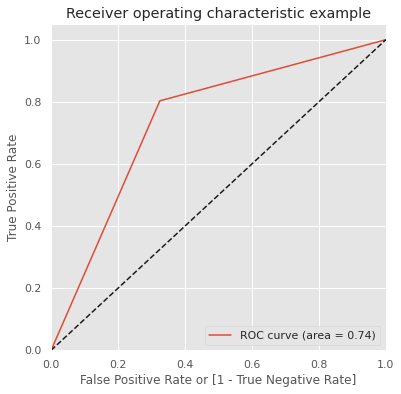

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
0,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
0,XG Boost basic - balance predict,0.75,0.72,0.82,0.75,0.72,0.82,0.75,0.75,0.75,0.75,0.75,0.75


In [99]:
dt_tree =  DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)
dt_tree.fit(X_train, y_train)
accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
temp = store_results("Decision tree with feature engine", y_train, X_train, y_test, X_test, \
                     dt_tree, 5)
draw_roc(dt_tree, X_test, y_test)
outcome = outcome.append(temp)
outcome

## Random forest model with feature engineering and balance precidtor.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
306155,0,0.12,0.12,0.13,0.06,0.14,0.11,0.17,0.00,0.00,1,2,320,50,2507,0,35,157,2,22,12
160654,0,0.12,0.12,0.13,0.08,0.07,0.11,0.17,0.01,0.16,1,0,320,50,2726,3,803,229,3,30,4


In [106]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
feature_importances = model_rf.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.24
9,device_model,0.22
20,hour,0.16
1,site_id,0.07
2,site_domain,0.05
4,app_id,0.05
19,day,0.04
18,dayofweek,0.03
14,C17,0.03
17,C21,0.02


using random forest feature importance metric to decide on best features and building the model.

['site_id', 'site_domain', 'app_id', 'device_ip', 'device_model', 'C17', 'dayofweek', 'day', 'hour']
9
Train results
accuracy 0.971267790868215
cnf_matrix 
 [[277559  12899]
 [  3792 286666]]
Test results
accuracy 0.8961777606400926
cnf_matrix 
 [[103276  21206]
 [  4642 119840]]


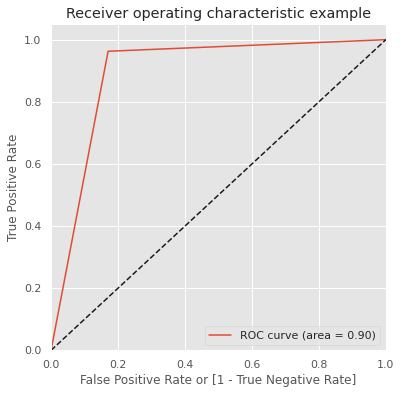

(array([0.        , 0.17035395, 1.        ]),
 array([0.        , 0.96270947, 1.        ]),
 array([2, 1, 0]))

In [107]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)
        
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
print(rf_cols)

print(len(rf_cols))
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = model_eval(model_rf, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

draw_roc(model_rf, X_test, y_test)


In [108]:
temp = store_results("Random Forest with feature engine", y_train, X_train, y_test, X_test, \
                     model_rf, 5)
outcome = outcome.append(temp)

In [109]:
outcome.reset_index(drop=True, inplace=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
1,logistic regres - imbalance predict,0.84,0.62,0.21,0.84,0.62,0.21,0.84,0.84,0.84,0.84,0.84,0.84
2,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
3,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.77,0.78,0.78
4,decision tree basic - balance predict,0.90,0.85,0.97,0.90,0.85,0.97,0.88,0.88,0.87,0.88,0.88,0.88
5,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.83,0.83,0.83,0.83,0.83
6,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
7,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
8,XGBoost basic - imbalance predict,0.85,0.64,0.22,0.85,0.64,0.22,0.85,0.85,0.85,0.85,0.85,0.85
9,XG Boost basic - balance predict,0.75,0.72,0.82,0.75,0.72,0.82,0.75,0.75,0.75,0.75,0.75,0.75


# conclusion
 If we have to select one model, Random forest classifier with feature enginnering looks promising and best. although after the feature engineering the training and test results looks same as before feature engineering, but model is very robust with new features and rightly fitted for both training and test dataset. 
 Decisiontree  and logistic regression classifer seems to have low accuracy, precision, and recall, overall random forest classifier seems doing better with all aspects.


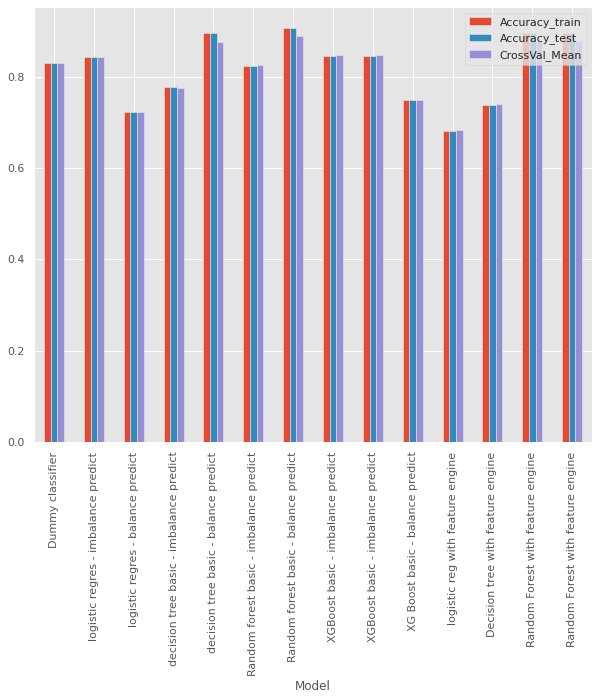

In [110]:
plt.rcParams["figure.figsize"] = (10,8)
outcome.plot(x='Model', y=['Accuracy_train','Accuracy_test','CrossVal_Mean'], kind="bar")
plt.xticks(rotation=90)
plt.show()

# Preparing test data for sumbission

In [111]:
test = pd.read_csv('../input/avazu-ctr-prediction/test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51


In [112]:
test['month'] = test['hour'].dt.month
test['dayofweek'] = test['hour'].dt.dayofweek
test['day'] = test['hour'].dt.day
test['hour_time'] = test['hour'].dt.hour
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23,10,4,31,0
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51,10,4,31,0


In [113]:
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = test[col].quantile(0.98)
    if test[col].quantile(0.98) < 0.5 * test[col].max():
        test[col][test[col] >= percentiles] = percentiles


In [114]:
'''
test.drop(['month', 'C20'], axis=1, inplace=True)
labelEncoder= LabelEncoder()
for col in (test.columns):
    if test[col].dtype == "object":
        test[col] = labelEncoder.fit_transform(test[col])

test.head(2)
'''

'\ntest.drop([\'month\', \'C20\'], axis=1, inplace=True)\nlabelEncoder= LabelEncoder()\nfor col in (test.columns):\n    if test[col].dtype == "object":\n        test[col] = labelEncoder.fit_transform(test[col])\n\ntest.head(2)\n'

In [115]:
test.drop(['id', 'hour'], axis = 1, inplace = True) 
test.rename(columns={'hour_time': 'hour'},
          inplace=True, errors='raise')
test.columns

Index(['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [116]:
test.drop(['month', 'C20'], axis=1, inplace=True)
test.drop(['C14', 'C1'], axis=1, inplace= True)

In [117]:
'''
for col in (test.columns):
    print(col)
    if test[col].dtype == "object":
        test[col] = target_encoder.transform(test)

test.head(2)
'''

'\nfor col in (test.columns):\n    print(col)\n    if test[col].dtype == "object":\n        test[col] = target_encoder.transform(test)\n\ntest.head(2)\n'

In [118]:
test =  target_encoder.transform(test)
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0,0.13,0.13,0.18,0.20,0.19,0.20,0.17,0.17,0.20,1,0,320,50,761,3,175,23,4,31,0
1,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.19,0.19,1,0,320,50,2616,0,35,51,4,31,0


In [119]:
test[test.columns]  = scaler.transform(test[test.columns])
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0.00,0.14,0.14,0.35,0.20,0.22,0.80,0.19,0.17,0.21,0.20,0.00,1.00,0.13,0.25,1.00,0.08,0.09,0.67,1.11,0.00
1,0.00,0.21,0.21,0.41,0.20,0.22,0.80,0.19,0.19,0.19,0.20,0.00,1.00,0.13,0.95,0.00,0.00,0.20,0.67,1.11,0.00


In [120]:
# random forest with balanced data was our best model, hence using the same for submission.
rf_cols

['site_id',
 'site_domain',
 'app_id',
 'device_ip',
 'device_model',
 'C17',
 'dayofweek',
 'day',
 'hour']

In [122]:
test = test[rf_cols]
predict_sub = model_rf.predict(test)
print(len(predict_sub))
print(print(len(submission)))
print(predict_sub)

4577464
4577464
None
[0 0 1 ... 1 0 0]


********************************************************** END **********************************************************